# Verifying Floodscan data with NiHSA observations

How well does our Floodscan data line up with the NiHSA observations?

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [43]:
import pandas as pd
import ocha_stratus as stratus
from src.constants import *
from src.datasources import nihsa
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np

SAPPHIRE = "#007ce0"
TOMATO = "#f2645a"
TOMATO_DARK = "#c25048"
TOMATO_LIGHT = "#f7a29c"
MINT = "#1ebfb3"
GREY_DARK = "#888888"
GREY_LIGHT = "#cccccc"

In [8]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/floodscan/fs_benue_pixels_1998_2024.parquet"
)
df_fs_pixels = stratus.load_parquet_from_blob(blob_name)

In [18]:
df_nihsa = nihsa.load_wuroboki().rename(columns={"time": "date"})

In [19]:
df_nihsa

,date,level
2,1954-05-25,398.0
3,1954-05-26,383.0
4,1954-05-27,389.0
5,1954-05-28,408.0
6,1954-05-29,404.0
...,...,...
27234,2024-12-27,458.0
27235,2024-12-28,455.0
27236,2024-12-29,451.0
27237,2024-12-30,457.0


In [16]:
df_fs_mean = df_fs_pixels.groupby("date")[["SFED"]].mean().reset_index()

In [20]:
df_merged = df_fs_mean.merge(df_nihsa)
df_merged["year"] = df_merged["date"].dt.year

In [25]:
df_merged_complete = df_merged[
    df_merged.year.isin(nihsa.WUROBOKI_COMPLETE_YEARS)
]

In [27]:
df_merged_complete.corr()

,date,SFED,level,year
date,1.000000,0.185615,0.457062,0.999020
SFED,0.185615,1.000000,0.611997,0.172143
level,0.457062,0.611997,1.000000,0.437714
year,0.999020,0.172143,0.437714,1.000000


In [51]:
df_peaks_fs = (
    df_merged_complete.groupby("year")
    .agg(
        sfed_max=("SFED", "max"),
        sfed_max_date=(
            "SFED",
            lambda x: df_merged_complete.loc[x.idxmax(), "date"],
        ),
    )
    .reset_index()
)

df_peaks_nihsa = (
    df_merged_complete.groupby("year")
    .agg(
        level_max=("level", "max"),
        level_max_date=(
            "level",
            lambda x: df_merged_complete.loc[x.idxmax(), "date"],
        ),
    )
    .reset_index()
)

rp = 3
rp_fs = df_peaks_fs["sfed_max"].quantile(1 - 1 / rp)
rp_nihsa = df_peaks_nihsa["level_max"].quantile(1 - 1 / rp)

In [28]:
def get_continuous_periods(mask):
    """Returns list of (start_idx, end_idx) tuples for continuous True periods in mask"""
    if not any(mask):
        return []

    mask_array = np.array(mask)
    result = []

    start_idx = None
    for i, val in enumerate(mask_array):
        if val and start_idx is None:  # Start of a run
            start_idx = i
        elif not val and start_idx is not None:  # End of a run
            result.append((start_idx, i - 1))
            start_idx = None

    # Handle case where the last run extends to the end
    if start_idx is not None:
        result.append((start_idx, len(mask_array) - 1))

    return result

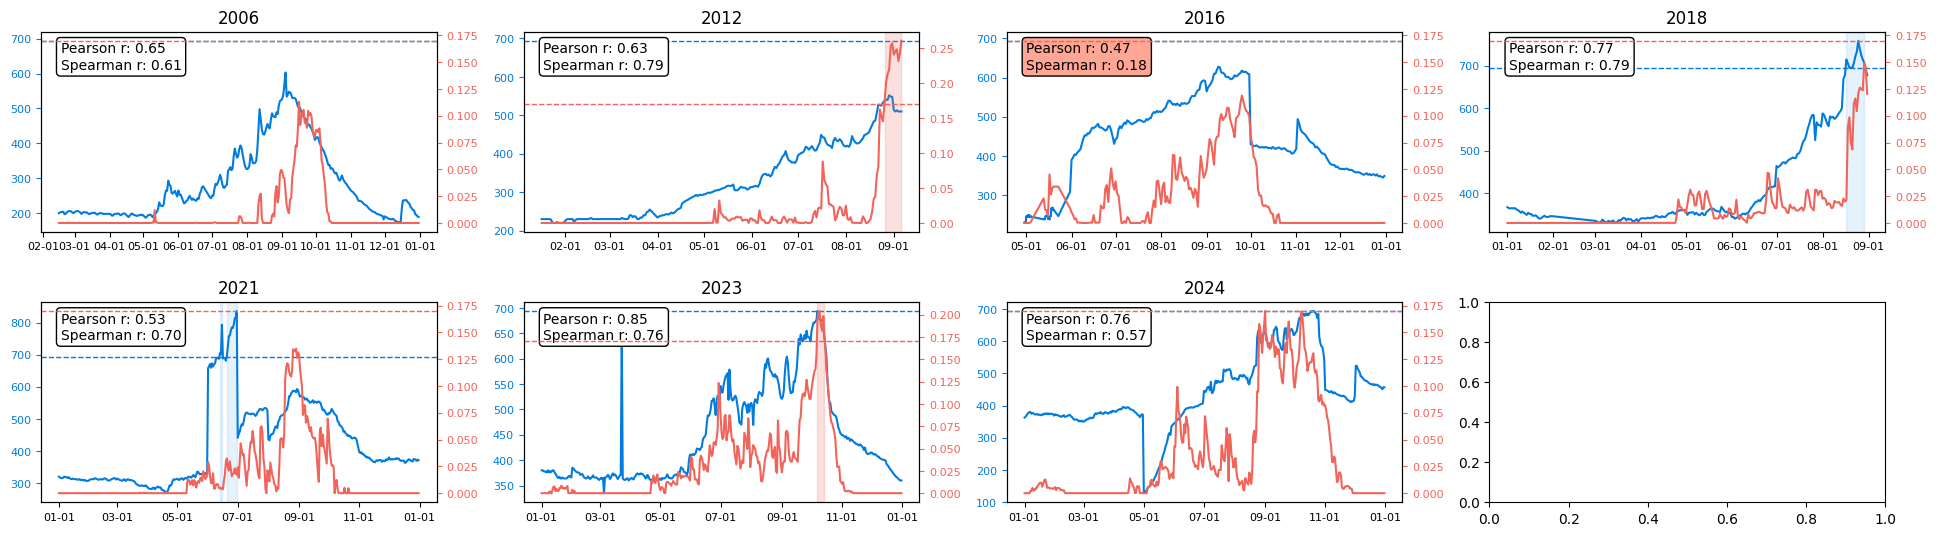

In [57]:
n_years = df_merged_complete["year"].nunique()
ncols = 4
nrows = round(n_years / ncols)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3)
)
axes = axes.flatten()
year_correlations = {}

for j, year in enumerate(df_merged_complete["year"].unique()):
    dff = df_merged_complete[df_merged_complete["date"].dt.year == year]
    ax = axes[j]
    ax2 = ax.twinx()

    ax.plot(dff["date"], dff["level"], c=SAPPHIRE)
    ax2.plot(dff["date"], dff["SFED"], c=TOMATO)

    axes[j].xaxis.set_major_formatter(DateFormatter("%m-%d"))

    # Color y-axis labels and ticks
    ax.tick_params(axis="y", colors=SAPPHIRE, labelsize=8)
    ax2.tick_params(axis="y", colors=TOMATO, labelsize=8)

    # Make x-axis font smaller
    ax.tick_params(axis="x", labelsize=8)

    # Highlight streamflow exceedances
    mask = dff["level"] > rp_nihsa
    for start_idx, end_idx in get_continuous_periods(mask):
        ax.axvspan(
            dff["date"].iloc[start_idx],
            dff["date"].iloc[end_idx],
            alpha=0.1,
            color=SAPPHIRE,
        )

    # Highlight SFED exceedances
    mask = dff["SFED"] > rp_fs
    for start_idx, end_idx in get_continuous_periods(mask):
        ax2.axvspan(
            dff["date"].iloc[start_idx],
            dff["date"].iloc[end_idx],
            alpha=0.2,
            color=TOMATO,
        )
    ax.axhline(rp_nihsa, lw=1, c=SAPPHIRE, linestyle="--")
    ax2.axhline(rp_fs, lw=1, c=TOMATO, linestyle="--")
    ax.set_title(year)

    pearson_r = dff["level"].corr(dff["SFED"], method="pearson")
    spearman_r = dff["level"].corr(dff["SFED"], method="spearman")

    year_correlations[year] = {
        "pearson_r": pearson_r,
        "spearman_r": spearman_r,
    }
    if pearson_r < 0.5 and spearman_r < 0.5:
        bbox_col = "#ffa694"  # Roughly which ones have bad relationship
    else:
        bbox_col = "white"

    ax.text(
        0.05,
        0.95,
        f"Pearson r: {pearson_r:.2f}\nSpearman r: {spearman_r:.2f}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor=bbox_col),
    )

# Add more spacing to avoid overlap
plt.tight_layout(h_pad=2.0, w_pad=1.0, pad=3.0)